# PCA classification: Dark Field data
Here, we will use Principal Component Analysis to reduce the dimensionality of the measured spectra, to visualize the spectra and to cluster the data, automatically assigning labels to different areas. First some preliminaries:

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from dask.distributed import Client
import time
import os
import xarray as xr

from pyL5.lib.analysis.container import Container

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def toniceRGB(image):
    """Use basis colors as suggested by P. Kovesi http://arxiv.org/abs/1509.03700"""
    A = np.array([[0.90, 0.17, 0.00],
                 [0.00, 0.50, 0.00],
                 [0.10, 0.33, 1.00]])
    return np.dot(image,A)

bRed = LinearSegmentedColormap.from_list('bRed', ['black', toniceRGB([1,0,0])], N=256)
bBlue = LinearSegmentedColormap.from_list('bBlue', ['black', toniceRGB([0,0,1])], N=256)
bGreen = LinearSegmentedColormap.from_list('bGreen', ['black', toniceRGB([0,1,0])], N=256)
cmaps = [bRed, bGreen, bBlue]*2
colors = [toniceRGB([1,0,0]), toniceRGB([0,1,0]), toniceRGB([0,0,1])]*2

client = Client()
client

<Client: 'tcp://127.0.0.1:62371' processes=4 threads=8, memory=34.23 GB>

In [24]:
"""Do a principle component analysis on a stack of images and use this for clustering, both using Dask"""
dimensions = 6
coarsen = 1

In [25]:
folder = './data'
name = '20171120_215555_3.5um_583.1_IVhdr_DF2'

# Clip out anything before mirror mode and a bit more because of image distortion
Erange = slice(100, 410)
x_slice = slice(442, 1380)
y_slice = slice(92, 960)
dset = da.from_zarr(os.path.join(folder, name + '_driftcorrected.zarr'))

IVs = dset[Erange, x_slice, y_slice].rechunk(chunks=(-1, 10 * coarsen, 10 * coarsen))
fullIVs = dset[:, x_slice, y_slice].rechunk(chunks=(-1, 10 * coarsen, 10 * coarsen))
IVs

dask.array<rechunk-merge, shape=(310, 938, 868), dtype=uint16, chunksize=(310, 10, 10), chunktype=numpy.ndarray>

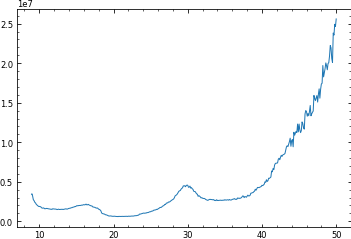

In [26]:
# Get metadata from netCDF file for plotting
xdata = xr.open_dataset(os.path.join(folder, name +'_detectorcorrected.nc'))
EGY = xdata.Energy_set
multiplier = xdata.multiplier
plt.plot(EGY, multiplier)

In [27]:
coarseIVs = IVs[:,::coarsen, ::coarsen].reshape((IVs.shape[0],-1)).T.persist()
pca = PCA(n_components=dimensions, whiten=True, random_state=4)
pipe = make_pipeline(StandardScaler(), pca)
pipe_names = '_'.join(pipe.named_steps.keys())
pipe_names

'standardscaler_pca'

In [28]:
pipe.fit(coarseIVs)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power=0, n_components=6,
                     random_state=4, svd_solver='auto', tol=0.0,
                     whiten=True))],
         verbose=False)

'6 PCA components explain 0.9194 of the total variance'

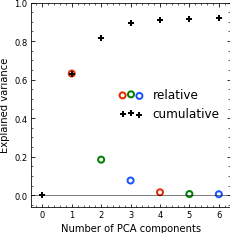

In [29]:
plt.figure(figsize=[3.5 ,3.5])
scree = np.concatenate([[0], pipe.named_steps['pca'].explained_variance_ratio_])
plt.scatter(np.arange(dimensions)+1, scree[1:], label='relative', facecolors='none', edgecolors=colors, linewidth=2)
plt.scatter(np.arange(dimensions+1), np.cumsum(scree), marker='+', label='cumulative', color='black', linewidth=2)
plt.ylabel('Explained variance')
plt.xlabel('Number of PCA components')
plt.axhline(0, color='black', alpha=0.5)
plt.legend(fontsize='large', scatterpoints=3)
plt.tight_layout()
plt.ylim([None,1])
plt.savefig(f'scree_plot_DF_{pipe_names}.pdf')
f"{dimensions} PCA components explain {scree.sum():.4f} of the total variance"

In [30]:
# Align signs with brightness in original pictures
pipe_diffs = pipe.inverse_transform(3*np.eye(6)).compute()
signs = np.sign(np.nanmean((np.log(pipe_diffs) - np.log(pipe.named_steps['standardscaler'].mean_)),axis=1))[:,np.newaxis]
print(signs)
pipe.named_steps['pca'].components_ *= signs

[[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]]


In [31]:
print('Transforming PCA')
rIVs = pipe.transform(IVs.reshape(IVs.shape[0], -1).T).persist()

Transforming PCA


In [32]:
argextrema = da.concatenate([rIVs[rIVs.argmin(axis=0), :], 
                             rIVs[rIVs.argmax(axis=0), :]])
argextrema = pipe.inverse_transform(argextrema) / multiplier[Erange]
argextrema = argextrema.reshape((2, 6, -1))

extrema = da.concatenate([da.diag(rIVs.min(axis=0)), 
                          da.diag(rIVs.max(axis=0))])
extrema = pipe.inverse_transform(extrema) / multiplier[Erange]
extrema = extrema.reshape((2, 6, -1))

argextrema, extrema = da.compute(argextrema, extrema)

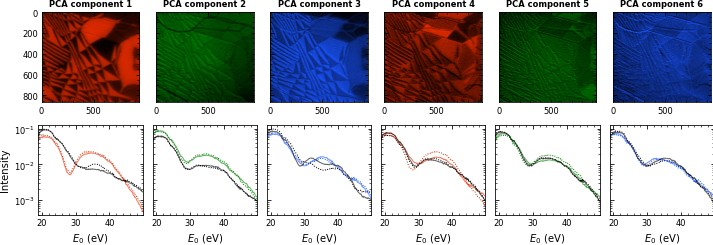

In [33]:
fig,axs = plt.subplots(2, dimensions, figsize=[10, 3.5],
                      sharex='row', sharey='row',
                      constrained_layout=True)
E = EGY[Erange]
for i in range(dimensions):
    axs[0,i].imshow(rIVs[:,i].reshape(IVs.shape[1:]).T, interpolation='none', cmap=cmaps[i])
    axs[0,i].set_title('PCA component {}'.format(i+1), fontsize='small')
    axs[1,i].plot(E, argextrema[1][i], color=cmaps[i](1.0), linestyle=':')
    axs[1,i].plot(E, argextrema[0][i], color=cmaps[i](0.0), linestyle=':')
    axs[1,i].plot(E, extrema[1][i], color=cmaps[i](1.0), alpha=0.6)
    axs[1,i].plot(E, extrema[0][i], color=cmaps[i](0.0), alpha=0.6)
    axs[1,i].set_yscale('log')
    axs[1,i].set_xlabel('$E_0$ (eV)')
    axs[1,i].margins(x=0)
axs[1,0].set_ylabel('Intensity')
plt.savefig(f'DF_PCAcomponents_{pipe_names}.pdf')

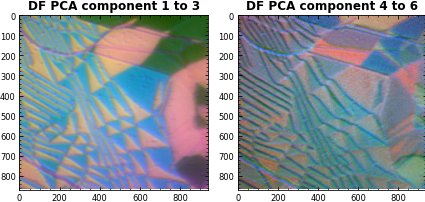

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[6, 3], constrained_layout=True)
img = rIVs[:, :3].reshape(IVs.shape[1:] + (3,)).swapaxes(0, 1)
img = img - img.min(axis=(0, 1), keepdims=True)
img = img / img.max(axis=(0, 1), keepdims=True)
ax1.imshow(toniceRGB(img), interpolation='none')
ax1.set_title('DF PCA component 1 to 3')

img = rIVs[:, 3:6].reshape(IVs.shape[1:] + (3,)).swapaxes(0, 1)
img = img - img.min(axis=(0, 1), keepdims=True)
img = img / img.max(axis=(0, 1), keepdims=True)
ax2.imshow(toniceRGB(img), interpolation='none')
ax2.set_title('DF PCA component 4 to 6')
plt.savefig(f'DF_visualization_{pipe_names}.pdf')

## Clustering: $k$-means
To assign labels to different spectra, we cluster using a standard unsupervised machine learning algorithm: $k$-means:

In [35]:
rIVs = rIVs.compute()
kmeans_d = 4

3 fit_predicted
3 clusters, score = 0.27615878882486006
4 fit_predicted
4 clusters, score = 0.2916079481808487
5 fit_predicted
5 clusters, score = 0.31718320736945166
6 fit_predicted
6 clusters, score = 0.33600690734402405
7 fit_predicted
7 clusters, score = 0.33430437776056116
8 fit_predicted
8 clusters, score = 0.34722582241038424
9 fit_predicted
9 clusters, score = 0.341905393858243
10 fit_predicted
10 clusters, score = 0.31959377434681424
11 fit_predicted
11 clusters, score = 0.32354915066678497


Text(0.5, 0, '$n_{clusters}$')

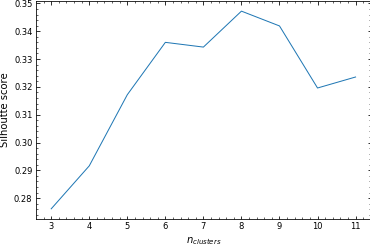

In [36]:
from sklearn.metrics import silhouette_samples, silhouette_score
scores = []
klabels = np.arange(3,12)
for n in klabels:
    clusterer = KMeans(n_clusters=n, random_state=10)
    cl_labels = clusterer.fit_predict(rIVs[::20,:kmeans_d])
    print(n, "fit_predicted")
    scores.append(silhouette_score(rIVs[::20,:kmeans_d], cl_labels))
    print(f"{n} clusters, score = {scores[-1]}")
plt.plot(klabels, scores)
plt.ylabel('Silhoutte score')
plt.xlabel('$n_{clusters}$')

In [37]:
print('Performing clustering via KMeans', rIVs[:,:kmeans_d].shape)
kmeans = KMeans(n_clusters=8, random_state=10, n_jobs=-1).fit(rIVs[:,:kmeans_d])
clustering = kmeans.predict(rIVs[:,:kmeans_d])

Performing clustering via KMeans (814184, 4)


For visualization of curves corresponding to clusters, we grab the full spectra, filter out points where the spectrum was not measured due to drift and calculate the mean per image per spectrum.

In [38]:
validIVs = da.where(fullIVs == 0, np.nan, fullIVs).reshape((fullIVs.shape[0],-1))
meanIVs = [da.nanmean(validIVs[:,clustering == index], axis=1) 
           for index in range(kmeans.n_clusters)]

plotting clustering data
Time elapsed: 2.183617115020752
Time elapsed: 38.114641189575195
Time elapsed: 40.4690797328949
Total time elapsed: 73.0377106666565


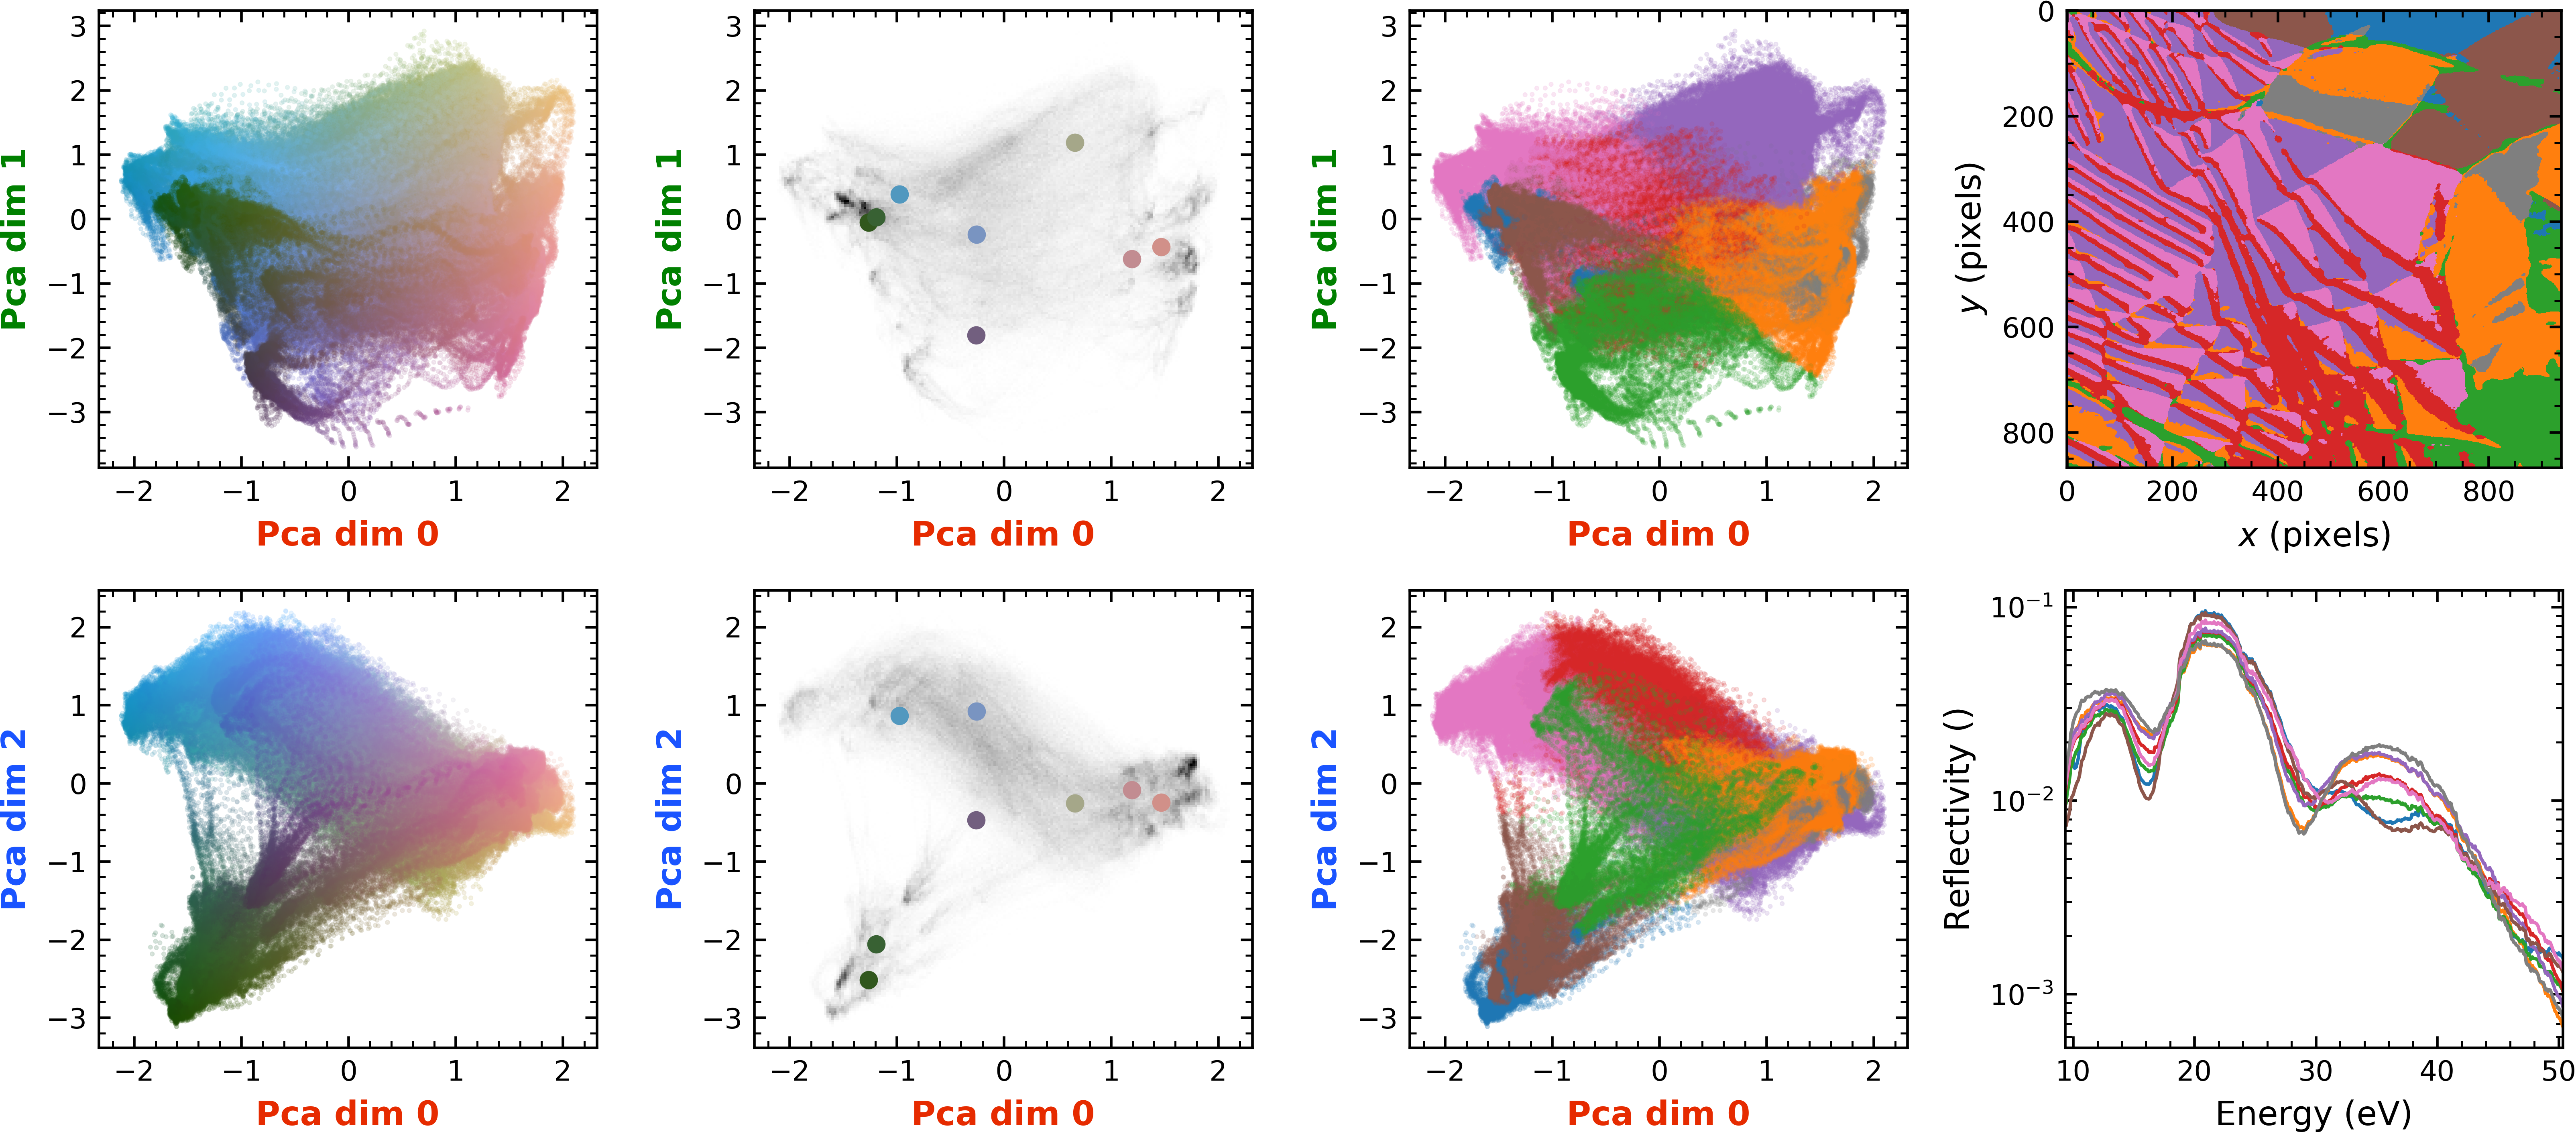

In [39]:
tstart = time.time()
print('plotting clustering data')


fig2,axs = plt.subplots(2,4, figsize=[11,5], dpi=600)
#In case of 1 out of 1 columns figure
axs = np.transpose(axs)

coarse_2d = 3*coarsen
color = rIVs[::coarse_2d,:3]
center_colors = kmeans.cluster_centers_[:,:3] - color.min(axis=0)
color = color - color.min(axis=0, keepdims=True)
center_colors = center_colors / color.max(axis=0)
center_colors = toniceRGB(center_colors)
color = color / color.max(axis=0,keepdims=True)
color = toniceRGB(color)

newcmap = ListedColormap(center_colors)

colorargs = {'cmap': newcmap, 'vmin': 0, 'vmax': 8}
axs[0,0].scatter(rIVs[::coarse_2d, 0], 
                 rIVs[::coarse_2d, 1], 
                 c=color, s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )
axs[0,1].scatter(rIVs[::coarse_2d, 0], 
                 rIVs[::coarse_2d, 2], 
                 c=color, s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )

for i in [0,1,2]:
    axs[i,0].set_ylabel("Pca dim 1", color=colors[1], fontweight=700)
    axs[i,0].set_xlabel("Pca dim 0", color=colors[0], fontweight=700)
    axs[i,1].set_ylabel("Pca dim 2", color=colors[2], fontweight=700)
    axs[i,1].set_xlabel("Pca dim 0", color=colors[0], fontweight=700)

hist, edges = np.histogramdd(rIVs[:,:3], bins=200,
                             range=[axs[0,0].get_xlim(), 
                                    axs[0,0].get_ylim(), 
                                    axs[0,1].get_ylim()])
edges = np.array(edges)
#xedges, yedges, zedges = edges[0], edges[1], edges[2]

axs[1,0].imshow(hist.sum(axis=-1)[:,::-1].T,
                extent=[edges[0,0], edges[0,-1], 
                        edges[1,0], edges[1,-1]],
                aspect='auto',
                cmap='gray_r')

axs[1,1].imshow(hist.sum(axis=1)[:,::-1].T, 
                extent=[edges[0,0], edges[0,-1],
                        edges[2,0], edges[2,-1]], 
                aspect='auto',
                cmap='gray_r')
colorargs['cmap'] = 'tab10'
colorargs['vmax'] = 10

axs[2,0].scatter(rIVs[::coarse_2d,0], rIVs[::coarse_2d,1], c=clustering[::coarse_2d], s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )
axs[2,1].scatter(rIVs[::coarse_2d,0], rIVs[::coarse_2d,2], c=clustering[::coarse_2d], s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )

clusteringimg = clustering.reshape((IVs.shape[1],IVs.shape[2]))
axs[3,0].imshow(clusteringimg.T,
                **colorargs
                )
for i,v in enumerate(kmeans.cluster_centers_):
    axs[1,0].scatter(v[0], v[1], s=20, color=center_colors[i])
    axs[1,1].scatter(v[0], v[2], s=20, color=center_colors[i])
print("Time elapsed: {}".format(time.time()-tstart))
meanIVs = da.compute(*meanIVs)
print("Time elapsed: {}".format(time.time()-tstart))
for i,meanIV in enumerate(meanIVs):
    axs[3,1].plot(xdata.Energy, (meanIV / multiplier),) # color=center_colors[i], alpha=0.75)

axs[3,1].set_yscale('log')
axs[3,1].set_xlabel('Energy (eV)')
axs[3,1].set_ylabel('Reflectivity ()')
axs[3,1].margins(x=0)
axs[3,0].set_xlabel(r'$x$ (pixels)')
axs[3,0].set_ylabel(r'$y$ (pixels)')

#In case of 1 out of two columns figure
#for ax in axs[:,1]:
    #ax.yaxis.set_label_position("right")
    #ax.tick_params(axis='y', labelright=True, labelleft=False)
    
plt.tight_layout()
print("Time elapsed: {}".format(time.time()-tstart))
plt.savefig('clustering_DF_2_0_perp.pdf', dpi=600)
print("Total time elapsed: {}".format(time.time()-tstart))

plotting clustering data
Time elapsed: 0.33890438079833984
Total time elapsed: 0.8643083572387695


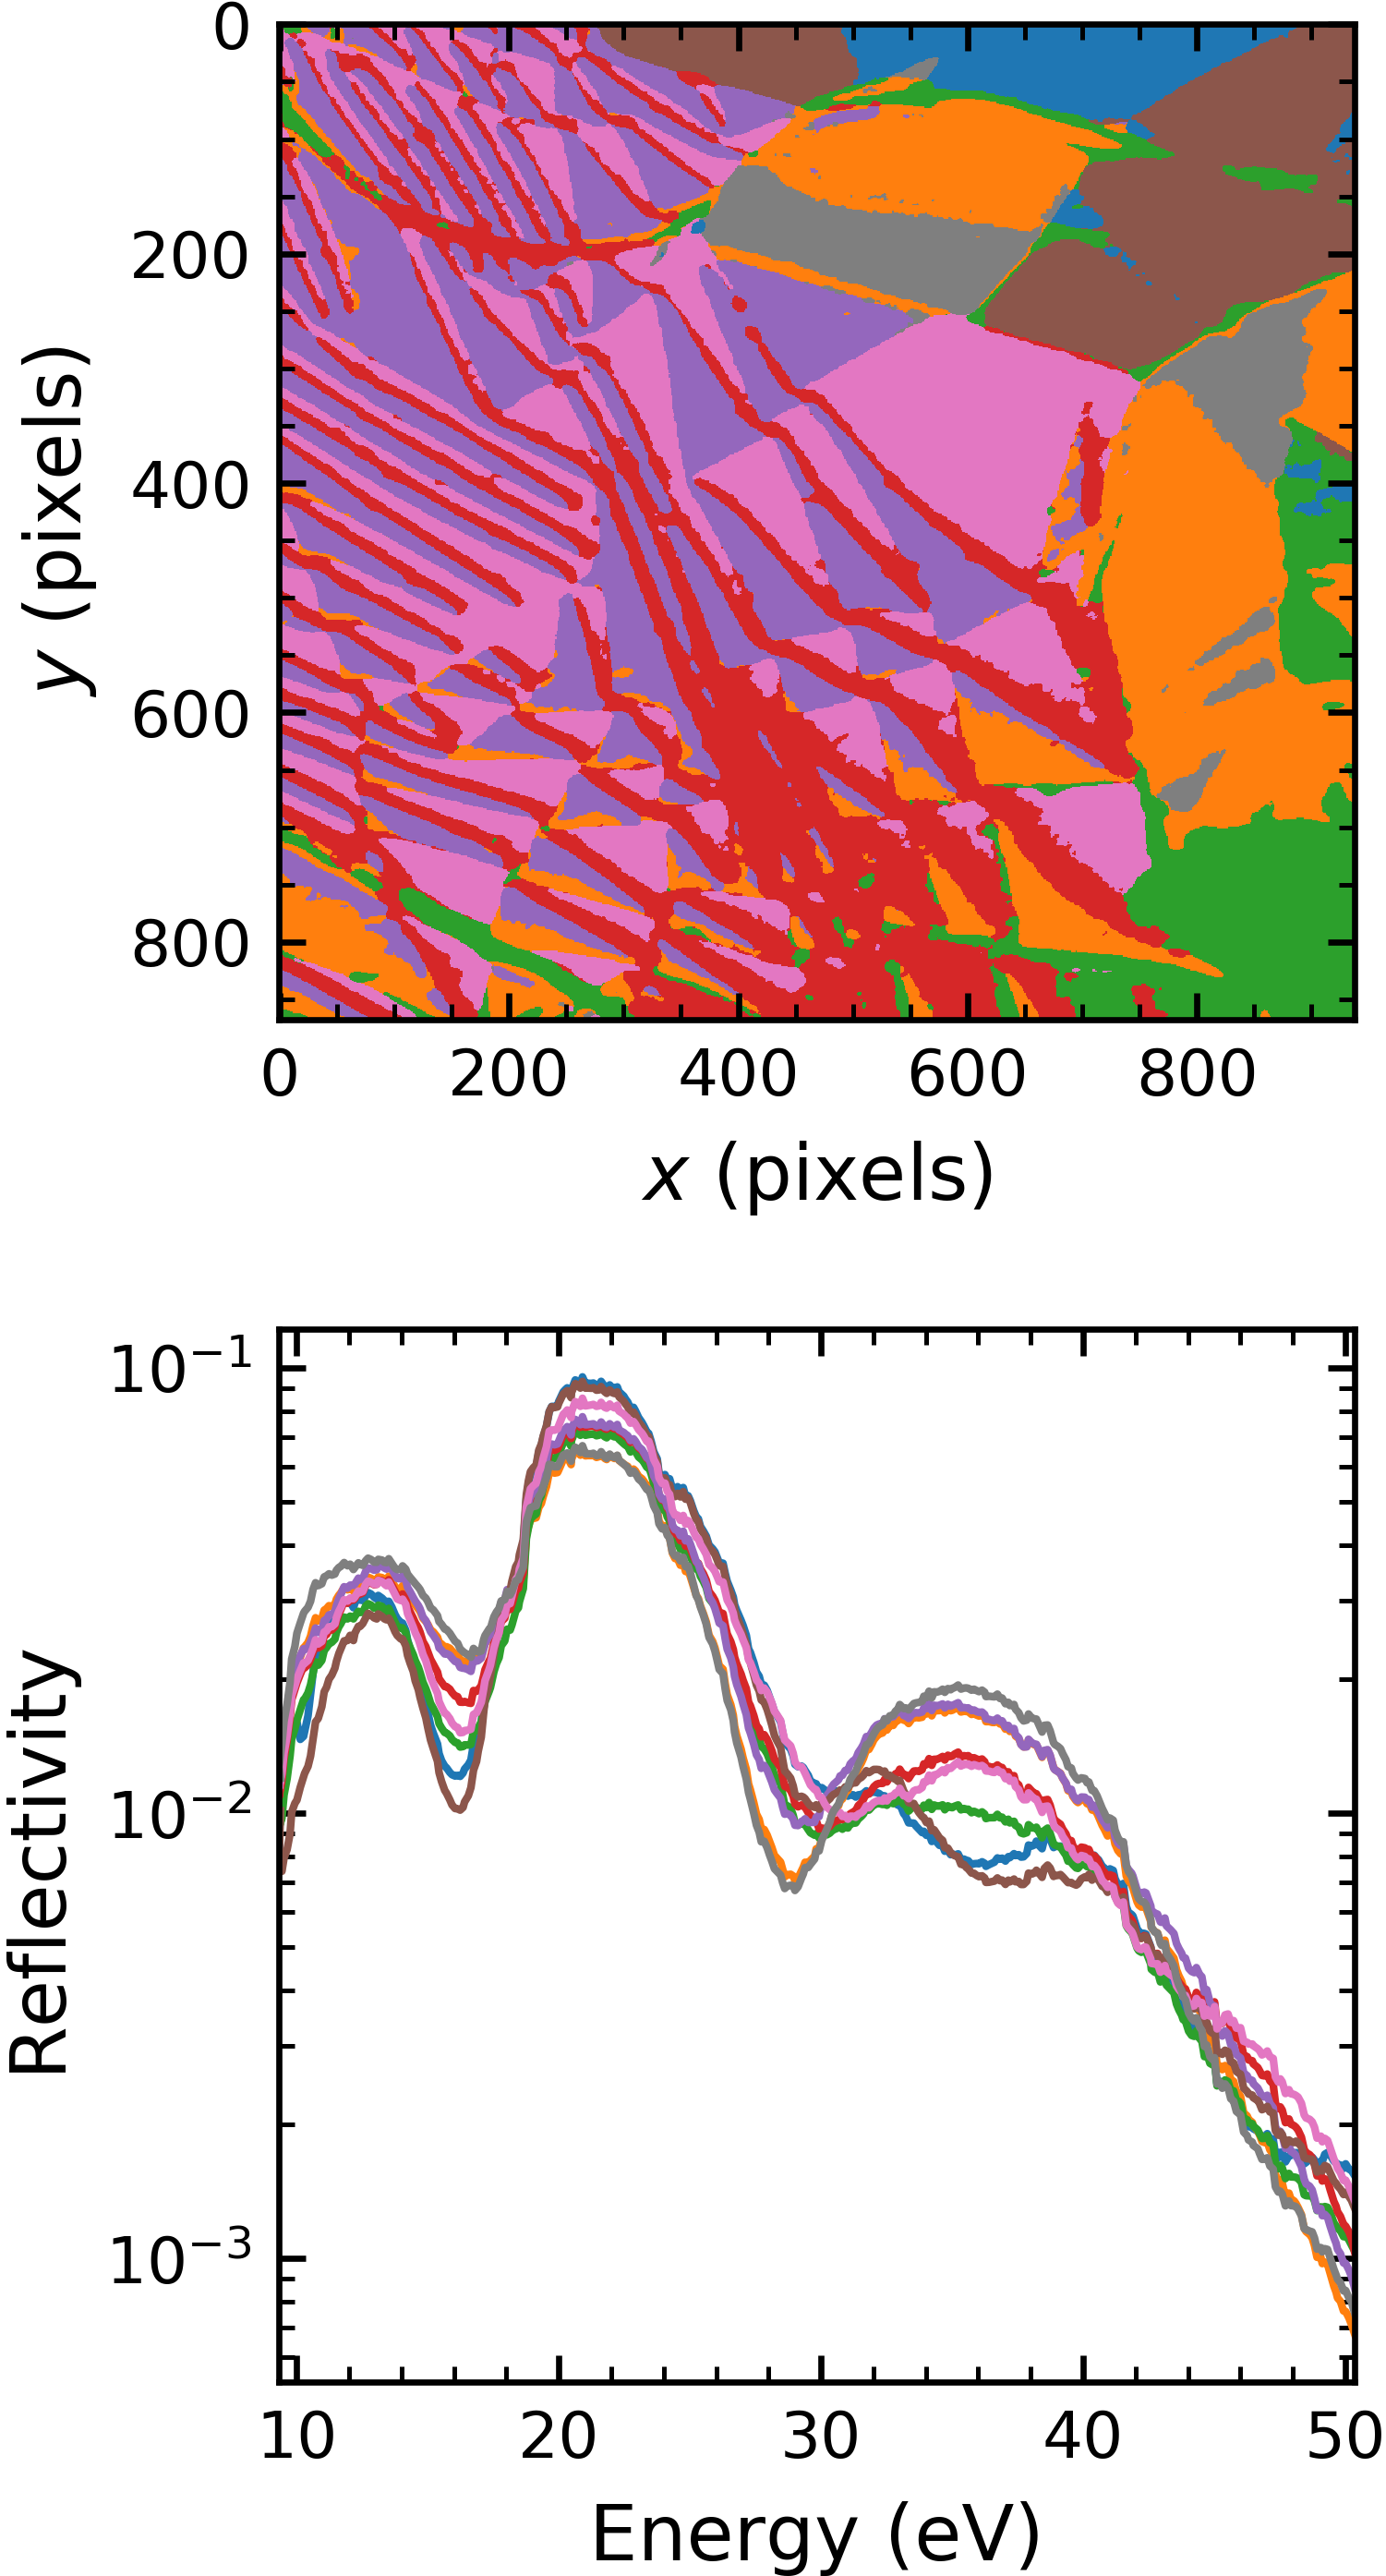

In [40]:
tstart = time.time()
print('plotting clustering data')


fig2 = plt.figure(figsize=[2.8,5], dpi=600)
axs = np.array([fig2.add_subplot(211), fig2.add_subplot(212)])

coarse_2d = 3*coarsen
color = rIVs[::coarse_2d,:3]
center_colors = kmeans.cluster_centers_[:,:3] - color.min(axis=0)
color = color - color.min(axis=0, keepdims=True)
center_colors = center_colors / color.max(axis=0)
center_colors = toniceRGB(center_colors)
color = color / color.max(axis=0,keepdims=True)
color = toniceRGB(color)

newcmap = ListedColormap(center_colors)

colorargs = {'cmap': newcmap, 'vmin': 0, 'vmax': 8}


edges = np.array(edges)
#xedges, yedges, zedges = edges[0], edges[1], edges[2]

colorargs['cmap'] = 'tab10'
colorargs['vmax'] = 10

clusteringimg = clustering.reshape((IVs.shape[1],IVs.shape[2]))
axs[0].imshow(clusteringimg.T,
                **colorargs
                )

for i,meanIV in enumerate(meanIVs):
    axs[1].plot(xdata.Energy, (meanIV / multiplier),) # color=center_colors[i], alpha=0.75)

axs[1].set_yscale('log')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Reflectivity')
axs[1].margins(x=0)
axs[0].set_xlabel(r'$x$ (pixels)')
axs[0].set_ylabel(r'$y$ (pixels)')

#In case of 1 out of two columns figure
#for ax in axs[:,1]:
    #ax.yaxis.set_label_position("right")
    #ax.tick_params(axis='y', labelright=True, labelleft=False)
    
plt.tight_layout()
print("Time elapsed: {}".format(time.time()-tstart))
plt.savefig('clustering_DF_3_0.pdf', dpi=600)
print("Total time elapsed: {}".format(time.time()-tstart))
